In [18]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from meteostat import Point, Daily
from geopy.geocoders import Nominatim
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [19]:
# --- Load Dataset ---
# Import the dataset uploaded to the repo
url = "https://raw.githubusercontent.com/MaharLeika18/Data-Mining---Python/refs/heads/main/Final_Exam/Raw%20Data.csv"
data = pd.read_csv(url)

print("Data loaded successfully!")
print(data.head())

Data loaded successfully!
   Order Date  Customer Name         State         Category Sub-Category  \
0  03-01-2014  Darren Powers         Texas  Office Supplies        Paper   
1  04-01-2014  Phillina Ober      Illinois  Office Supplies       Labels   
2  04-01-2014  Phillina Ober      Illinois  Office Supplies      Storage   
3  04-01-2014  Phillina Ober      Illinois  Office Supplies      Binders   
4  05-01-2014     Mick Brown  Pennsylvania  Office Supplies          Art   

                                        Product Name   Sales  Quantity  Profit  
0  Message Book, Wirebound, Four 5 1/2" X 4" Form...   16.45         2    5.55  
1                                          Avery 508   11.78         3    4.27  
2                      SAFCO Boltless Steel Shelving  272.74         3  -64.77  
3         GBC Standard Plastic Binding Systems Combs    3.54         2   -5.49  
4  Avery Hi-Liter EverBold Pen Style Fluorescent ...   19.54         3    4.88  


In [20]:
# --- Data Preprocessing ---
# Create id column
data['Transaction ID'] = data.index + 1

# Convert dates to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y')
start = data['Order Date'].min()
end = data['Order Date'].max()
print(f"Date range: {start.date()} to {end.date()}")

# Convert states to coordinates
# LOUE NOTE: FULL DISCLAIMER I had chatgpt gen these coords cuz no way am i doing this manually.
# so if the cords are innacurate im sorry
# or well chatgpt should be sorry but unlike caine its not sentient

state_coords = {
    "Alabama": (32.806671, -86.791130),
    "Alaska": (61.370716, -152.404419),
    "Arizona": (33.729759, -111.431221),
    "Arkansas": (34.969704, -92.373123),
    "California": (36.116203, -119.681564),
    "Colorado": (39.059811, -105.311104),
    "Connecticut": (41.597782, -72.755371),
    "Delaware": (39.318523, -75.507141),
    "Florida": (27.766279, -81.686783),
    "Georgia": (33.040619, -83.643074),
    "Hawaii": (21.094318, -157.498337),
    "Idaho": (44.240459, -114.478828),
    "Illinois": (40.349457, -88.986137),
    "Indiana": (39.849426, -86.258278),
    "Iowa": (42.011539, -93.210526),
    "Kansas": (38.526600, -96.726486),
    "Kentucky": (37.668140, -84.670067),
    "Louisiana": (31.169546, -91.867805),
    "Maine": (44.693947, -69.381927),
    "Maryland": (39.063946, -76.802101),
    "Massachusetts": (42.230171, -71.530106),
    "Michigan": (43.326618, -84.536095),
    "Minnesota": (45.694454, -93.900192),
    "Mississippi": (32.741646, -89.678696),
    "Missouri": (38.456085, -92.288368),
    "Montana": (46.921925, -110.454353),
    "Nebraska": (41.125370, -98.268082),
    "Nevada": (38.313515, -117.055374),
    "New Hampshire": (43.452492, -71.563896),
    "New Jersey": (40.298904, -74.521011),
    "New Mexico": (34.840515, -106.248482),
    "New York": (42.165726, -74.948051),
    "North Carolina": (35.630066, -79.806419),
    "North Dakota": (47.528912, -99.784012),
    "Ohio": (40.388783, -82.764915),
    "Oklahoma": (35.565342, -96.928917),
    "Oregon": (44.572021, -122.070938),
    "Pennsylvania": (40.590752, -77.209755),
    "Rhode Island": (41.680893, -71.511780),
    "South Carolina": (33.856892, -80.945007),
    "South Dakota": (44.299782, -99.438828),
    "Tennessee": (35.747845, -86.692345),
    "Texas": (31.054487, -97.563461),
    "Utah": (40.150032, -111.862434),
    "Vermont": (44.045876, -72.710686),
    "Virginia": (37.769337, -78.169968),
    "Washington": (47.400902, -121.490494),
    "West Virginia": (38.491226, -80.954456),
    "Wisconsin": (44.268543, -89.616508),
    "Wyoming": (42.755966, -107.302490)
}

data['Coords'] = data['State'].map(state_coords)
data[['Latitude', 'Longitude']] = pd.DataFrame(data['Coords'].tolist(), index=data.index)

data

Date range: 2014-01-03 to 2017-12-30


,Order Date,Customer Name,State,Category,Sub-Category,Product Name,Sales,Quantity,Profit,Transaction ID,Coords,Latitude,Longitude
0,2014-01-03,Darren Powers,Texas,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.45,2,5.55,1,"(31.054487, -97.563461)",31.054487,-97.563461
1,2014-01-04,Phillina Ober,Illinois,Office Supplies,Labels,Avery 508,11.78,3,4.27,2,"(40.349457, -88.986137)",40.349457,-88.986137
2,2014-01-04,Phillina Ober,Illinois,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.74,3,-64.77,3,"(40.349457, -88.986137)",40.349457,-88.986137
3,2014-01-04,Phillina Ober,Illinois,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.54,2,-5.49,4,"(40.349457, -88.986137)",40.349457,-88.986137
4,2014-01-05,Mick Brown,Pennsylvania,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.54,3,4.88,5,"(40.590752, -77.209755)",40.590752,-77.209755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2017-12-30,Patrick O'Donnell,New York,Technology,Phones,Gear Head AU3700S Headset,90.93,7,2.73,9990,"(42.165726, -74.948051)",42.165726,-74.948051
9990,2017-12-30,Patrick O'Donnell,New York,Office Supplies,Binders,Wilson Jones Legal Size Ring Binders,52.78,3,19.79,9991,"(42.165726, -74.948051)",42.165726,-74.948051
9991,2017-12-30,Erica Bern,California,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.90,2,4.52,9992,"(36.116203, -119.681564)",36.116203,-119.681564
9992,2017-12-30,Erica Bern,California,Office Supplies,Binders,GBC Binding covers,20.72,2,6.48,9993,"(36.116203, -119.681564)",36.116203,-119.681564


In [21]:
# --- Get State-Specific Weather Data ---
print("\nGetting state-specific weather data...")

weather_data_list = []

# Get weather data
states_with_data = 0
for state, coords in state_coords.items():
    try:
        lat, lon = coords
        location = Point(lat, lon)
        state_weather = Daily(location, start, end).fetch()
        
        if not state_weather.empty:
            state_weather = state_weather.reset_index()
            state_weather['State'] = state
            weather_data_list.append(state_weather)
            states_with_data += 1
            print(f"✓ Weather data retrieved for {state}")
    except Exception as e:
        print(f"✗ Failed to fetch weather for {state}: {e}")
        continue

if weather_data_list:
    # Combine all state weather data
    weather_data = pd.concat(weather_data_list, ignore_index=True)
    print(f"\n✓ Successfully retrieved weather data for {states_with_data}/{len(state_coords)} states")
else:
    print("\n✗ No state weather data retrieved, using central US fallback for all states...")
    try:
        central_location = Point(39.8283, -98.5795)
        weather_data = Daily(central_location, start, end).fetch()
        if not weather_data.empty:
            weather_data = weather_data.reset_index()
            # Create records for all states with central US data
            all_states_weather = []
            for state in state_coords.keys():
                state_weather = weather_data.copy()
                state_weather['State'] = state
                all_states_weather.append(state_weather)
            weather_data = pd.concat(all_states_weather, ignore_index=True)
            print("✓ Using central US weather data for all states")
    except Exception as e:
        print(f"✗ Central US fallback also failed: {e}")
        print("Creating mock weather data for all states...")
        date_range = pd.date_range(start=start, end=end, freq='D')
        all_states_weather = []
        for state in state_coords.keys():
            mock_weather = pd.DataFrame({
                'time': date_range,
                'tavg': np.random.normal(15, 10, len(date_range)),
                'prcp': np.random.exponential(2, len(date_range)),
                'wspd': np.random.normal(10, 5, len(date_range)),
                'State': state
            })
            all_states_weather.append(mock_weather)
        weather_data = pd.concat(all_states_weather, ignore_index=True)

if not weather_data.empty:
    print(f"Weather data shape: {weather_data.shape}")
    print("Weather data sample (showing different states):")
    print(weather_data[['time', 'State', 'tavg', 'prcp']].drop_duplicates(['time', 'State']).head(10))
else:
    print("No weather data available")
    weather_data = pd.DataFrame()

print(weather_data)


Getting state-specific weather data...
✓ Weather data retrieved for Arkansas
✓ Weather data retrieved for California
✓ Weather data retrieved for Connecticut
✓ Weather data retrieved for Florida
✓ Weather data retrieved for Hawaii
✓ Weather data retrieved for Illinois
✓ Weather data retrieved for Indiana
✓ Weather data retrieved for Iowa
✓ Weather data retrieved for Kentucky
✓ Weather data retrieved for Maine
✓ Weather data retrieved for Maryland
✓ Weather data retrieved for Massachusetts
✓ Weather data retrieved for Michigan
✓ Weather data retrieved for Minnesota
✓ Weather data retrieved for Missouri
✓ Weather data retrieved for Nebraska
✓ Weather data retrieved for Nevada
✓ Weather data retrieved for New Hampshire
✓ Weather data retrieved for New Jersey
✓ Weather data retrieved for New York
✓ Weather data retrieved for North Carolina
✓ Weather data retrieved for Ohio
✓ Weather data retrieved for Oklahoma
✓ Weather data retrieved for Rhode Island
✓ Weather data retrieved for South Ca

In [22]:
# Clean and Aggregate Weather Data 
if not weather_data.empty:
    # Replace any problematic values with NaN
    weather_data = weather_data.replace(['<NA>', 'NA', 'NaN', ''], np.nan)
    
    # Fill missing values with column means
    numeric_cols = ['tavg', 'prcp', 'wspd']
    for col in numeric_cols:
        if col in weather_data.columns:
            # Convert to numeric first
            weather_data[col] = pd.to_numeric(weather_data[col], errors='coerce')
            # Fill with mean
            weather_data[col] = weather_data[col].fillna(weather_data[col].mean())
    
    # AGGREGATE
    weather_data_clean = weather_data.groupby(['time', 'State']).agg({
        'tavg': 'mean',
        'prcp': 'mean', 
        'wspd': 'mean'
    }).reset_index()
    
    print("Weather data after cleaning and aggregation:")
    print(f"Shape: {weather_data_clean.shape}")
    print(f"Unique state-date combinations: {weather_data_clean[['time', 'State']].drop_duplicates().shape[0]}")
    print("Should equal the shape above if no duplicates")
    print(weather_data_clean.head())
else:
    print("No weather data to clean")
    weather_data_clean = pd.DataFrame()

print(weather_data_clean)

Weather data after cleaning and aggregation:
Shape: (45162, 5)
Unique state-date combinations: 45162
Should equal the shape above if no duplicates
        time        State       tavg      prcp       wspd
0 2014-01-03     Arkansas       -3.6       0.0       12.2
1 2014-01-03   California        7.6       0.0        2.6
2 2014-01-03  Connecticut      -12.9  2.174218       19.2
3 2014-01-03      Florida        8.8  2.174218       19.1
4 2014-01-03       Hawaii  12.263582      23.4  11.193496
            time        State       tavg      prcp       wspd
0     2014-01-03     Arkansas       -3.6       0.0       12.2
1     2014-01-03   California        7.6       0.0        2.6
2     2014-01-03  Connecticut      -12.9  2.174218       19.2
3     2014-01-03      Florida        8.8  2.174218       19.1
4     2014-01-03       Hawaii  12.263582      23.4  11.193496
...          ...          ...        ...       ...        ...
45157 2017-12-30        Texas        8.4  2.174218       12.1
45158 201

In [23]:
# Merge Data (States)
if not weather_data_clean.empty:
    # Check for duplicates in both datasets before merge
    print("Before merge:")
    print(f"Original data unique transactions: {data[['Order Date', 'State', 'Transaction ID']].drop_duplicates().shape[0]}")
    print(f"Weather data unique state-dates: {weather_data_clean[['time', 'State']].drop_duplicates().shape[0]}")
    
    # Merge using BOTH Date and State
    data_with_weather = pd.merge(
        data.rename(columns={'Order Date': 'Date'}), 
        weather_data_clean.rename(columns={'time': 'Date'}), 
        on=['Date', 'State'],
        how='left'
    )
    
    # Fill any remaining missing values with column means
    for col in ['tavg', 'prcp', 'wspd']:
        if col in data_with_weather.columns:
            data_with_weather[col] = data_with_weather[col].fillna(data_with_weather[col].mean())
    
    print(f"\n✓ Successfully merged state-specific weather data")
    print(f"Original data shape: {data.shape}")
    print(f"Final data shape: {data_with_weather.shape}")
    
    # Verify no duplication
    if len(data_with_weather) == len(data):
        print("No duplication - row count matches original data")
    else:
        print(f" DUPLICATION DETECTED - original: {len(data)}, merged: {len(data_with_weather)}")
        print("Checking for duplicate transactions...")
        duplicates = data_with_weather[data_with_weather.duplicated(['Transaction ID'], keep=False)]
        print(f"Duplicate transactions found: {len(duplicates)}")
        
    print("\nSample of merged data:")
    print(data_with_weather[['Date', 'State', 'Transaction ID', 'tavg', 'prcp', 'wspd']].head(10))
else:
    print("No weather data available for merging")
    data_with_weather = data.copy()
    # Add default weather columns
    data_with_weather['tavg'] = 15.0
    data_with_weather['prcp'] = 0.0
    data_with_weather['wspd'] = 10.0

print(data_with_weather)

Before merge:
Original data unique transactions: 9994
Weather data unique state-dates: 45162

✓ Successfully merged state-specific weather data
Original data shape: (9994, 13)
Final data shape: (9994, 16)
No duplication - row count matches original data

Sample of merged data:
        Date         State  Transaction ID       tavg      prcp       wspd
0 2014-01-03         Texas               1        3.7       0.0       11.4
1 2014-01-04      Illinois               2       -3.1  2.174218       29.5
2 2014-01-04      Illinois               3       -3.1  2.174218       29.5
3 2014-01-04      Illinois               4       -3.1  2.174218       29.5
4 2014-01-05  Pennsylvania               5  14.326056   1.81915  10.866375
5 2014-01-06    California               6        7.5       0.0        3.0
6 2014-01-06       Georgia               7  14.326056   1.81915  10.866375
7 2014-01-06      Kentucky               8      -13.7  2.174218       28.4
8 2014-01-06      Kentucky               9     

In [24]:
# Drop unnecessary cols, concat product categories + name
data_with_weather = data_with_weather.drop(columns=['Coords', 'Latitude', 'Longitude'])
data_with_weather['Item'] = data_with_weather['Category'] + '_' + data_with_weather['Sub-Category'] + '_' + data_with_weather['Product Name']

# Aggregate Item by ID
data_with_weather = (
    data_with_weather.groupby("Transaction ID")
        .agg({
            "Item": lambda x: ", ".join(x),
            **{col: "first" for col in data_with_weather.columns if col not in ["Transaction ID", "Item"]}
        })
        .reset_index()
)

# Export 
data_with_weather.to_csv('retail_data_with_weather.csv', index=False)
display(data_with_weather)

,Transaction ID,Item,Date,Customer Name,State,Category,Sub-Category,Product Name,Sales,Quantity,Profit,tavg,prcp,wspd
0,1,"Office Supplies_Paper_Message Book, Wirebound,...",2014-01-03,Darren Powers,Texas,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.45,2,5.55,3.7,0.0,11.4
1,2,Office Supplies_Labels_Avery 508,2014-01-04,Phillina Ober,Illinois,Office Supplies,Labels,Avery 508,11.78,3,4.27,-3.1,2.174218,29.5
2,3,Office Supplies_Storage_SAFCO Boltless Steel S...,2014-01-04,Phillina Ober,Illinois,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.74,3,-64.77,-3.1,2.174218,29.5
3,4,Office Supplies_Binders_GBC Standard Plastic B...,2014-01-04,Phillina Ober,Illinois,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.54,2,-5.49,-3.1,2.174218,29.5
4,5,Office Supplies_Art_Avery Hi-Liter EverBold Pe...,2014-01-05,Mick Brown,Pennsylvania,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.54,3,4.88,14.326056,1.81915,10.866375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,Technology_Phones_Gear Head AU3700S Headset,2017-12-30,Patrick O'Donnell,New York,Technology,Phones,Gear Head AU3700S Headset,90.93,7,2.73,-12.7,3.6,11.5
9990,9991,Office Supplies_Binders_Wilson Jones Legal Siz...,2017-12-30,Patrick O'Donnell,New York,Office Supplies,Binders,Wilson Jones Legal Size Ring Binders,52.78,3,19.79,-12.7,3.6,11.5
9991,9992,Office Supplies_Binders_Cardinal Slant-D Ring ...,2017-12-30,Erica Bern,California,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.90,2,4.52,6.5,0.0,1.3
9992,9993,Office Supplies_Binders_GBC Binding covers,2017-12-30,Erica Bern,California,Office Supplies,Binders,GBC Binding covers,20.72,2,6.48,6.5,0.0,1.3


In [25]:
# --- One-hot encode categorical data ---
transactions = data_with_weather.groupby('Transaction ID')['Item'].apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

df.head()

,"Furniture_Bookcases_Atlantic Metals Mobile 2-Shelf Bookcases, Custom Colors","Furniture_Bookcases_Atlantic Metals Mobile 3-Shelf Bookcases, Custom Colors","Furniture_Bookcases_Atlantic Metals Mobile 4-Shelf Bookcases, Custom Colors","Furniture_Bookcases_Atlantic Metals Mobile 5-Shelf Bookcases, Custom Colors",Furniture_Bookcases_Bestar Classic Bookcase,"Furniture_Bookcases_Bush Andora Bookcase, Maple/Graphite Gray Finish","Furniture_Bookcases_Bush Birmingham Collection Bookcase, Dark Cherry","Furniture_Bookcases_Bush Cubix Collection Bookcases, Fully Assembled","Furniture_Bookcases_Bush Heritage Pine Collection 5-Shelf Bookcase, Albany Pine Finish, *Special Order",Furniture_Bookcases_Bush Mission Pointe Library,...,Technology_Phones_Wireless Extenders zBoost YX545 SOHO Signal Booster,Technology_Phones_Xblue XB-1670-86 X16 Small Office Telephone - Titanium,Technology_Phones_Xiaomi Mi3,Technology_Phones_i.Sound Portable Power - 8000 mAh,Technology_Phones_iHome FM Clock Radio with Lightning Dock,"Technology_Phones_iKross Bluetooth Portable Keyboard + Cell Phone Stand Holder + Brush for Apple iPhone 5S 5C 5, 4S 4",Technology_Phones_iOttie HLCRIO102 Car Mount,Technology_Phones_iOttie XL Car Mount,Technology_Phones_invisibleSHIELD by ZAGG Smudge-Free Screen Protector,Technology_Phones_netTALK DUO VoIP Telephone Service
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
# --- One-hot encode categorical data ---
data['Item'] = data['Category'] + '_' + data['Sub-Category'] + '_' + data['Product Name']
transactions = data.groupby('Transaction ID')['Item'].apply(list).tolist()

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

df.head()

,"Furniture_Bookcases_Atlantic Metals Mobile 2-Shelf Bookcases, Custom Colors","Furniture_Bookcases_Atlantic Metals Mobile 3-Shelf Bookcases, Custom Colors","Furniture_Bookcases_Atlantic Metals Mobile 4-Shelf Bookcases, Custom Colors","Furniture_Bookcases_Atlantic Metals Mobile 5-Shelf Bookcases, Custom Colors",Furniture_Bookcases_Bestar Classic Bookcase,"Furniture_Bookcases_Bush Andora Bookcase, Maple/Graphite Gray Finish","Furniture_Bookcases_Bush Birmingham Collection Bookcase, Dark Cherry","Furniture_Bookcases_Bush Cubix Collection Bookcases, Fully Assembled","Furniture_Bookcases_Bush Heritage Pine Collection 5-Shelf Bookcase, Albany Pine Finish, *Special Order",Furniture_Bookcases_Bush Mission Pointe Library,...,Technology_Phones_Wireless Extenders zBoost YX545 SOHO Signal Booster,Technology_Phones_Xblue XB-1670-86 X16 Small Office Telephone - Titanium,Technology_Phones_Xiaomi Mi3,Technology_Phones_i.Sound Portable Power - 8000 mAh,Technology_Phones_iHome FM Clock Radio with Lightning Dock,"Technology_Phones_iKross Bluetooth Portable Keyboard + Cell Phone Stand Holder + Brush for Apple iPhone 5S 5C 5, 4S 4",Technology_Phones_iOttie HLCRIO102 Car Mount,Technology_Phones_iOttie XL Car Mount,Technology_Phones_invisibleSHIELD by ZAGG Smudge-Free Screen Protector,Technology_Phones_netTALK DUO VoIP Telephone Service
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [27]:
# Prepare TRANSACTION-LEVEL Data for Clustering 
print("PREPARING TRANSACTION-LEVEL CLUSTERING \n")

transaction_data = data_with_weather.copy()

# Select features for transaction clustering
features_for_clustering = ['Sales', 'Quantity', 'Profit', 'tavg', 'wspd', 'prcp']

print(f"Transaction data shape: {transaction_data.shape}")
print(f"Features for clustering: {features_for_clustering}")
print("\nTransaction data summary:")
print(transaction_data[features_for_clustering].describe())

print("\nSample transactions for clustering:")
print(transaction_data[['Customer Name', 'Sales', 'Quantity', 'Profit', 'tavg', 'prcp']].head(10))

PREPARING TRANSACTION-LEVEL CLUSTERING 

Transaction data shape: (9994, 14)
Features for clustering: ['Sales', 'Quantity', 'Profit', 'tavg', 'wspd', 'prcp']

Transaction data summary:
              Sales     Quantity       Profit       tavg       wspd      prcp
count   9994.000000  9994.000000  9994.000000     9994.0     9994.0    9994.0
mean     229.858022     3.789574    28.656973  14.326056  10.866375   1.81915
std      623.245131     2.225110   234.260203   8.472209   5.062333  3.376456
min        0.440000     1.000000 -6599.980000      -26.7        0.0       0.0
25%       17.280000     2.000000     1.730000       10.8        8.0       0.0
50%       54.490000     3.000000     8.665000  14.326056  10.866375   1.81915
75%      209.940000     5.000000    29.360000       19.9       12.5  2.174218
max    22638.480000    14.000000  8399.980000       33.2       44.7      82.0

Sample transactions for clustering:
      Customer Name    Sales  Quantity  Profit       tavg      prcp
0     Dar

In [28]:
# transaction clustering - weather only
transaction_clustering_features = [
    'tavg',
    'wspd',
    'prcp'
]

X_transaction_cluster = data_with_weather[transaction_clustering_features].fillna(0)
X_transaction_cluster = X_transaction_cluster.replace([np.inf, -np.inf], 0)

scaler_transaction = StandardScaler()
X_transaction_scaled = scaler_transaction.fit_transform(X_transaction_cluster)

print("Transaction-level features for clustering:")
print(transaction_clustering_features)
print(f"Transaction data shape: {X_transaction_scaled.shape}")
print(f"Number of transactions: {X_transaction_scaled.shape[0]}")

Transaction-level features for clustering:
['tavg', 'wspd', 'prcp']
Transaction data shape: (9994, 3)
Number of transactions: 9994


K=2: WCSS = 23110.00, Silhouette = 0.447
K=3: WCSS = 17232.75, Silhouette = 0.432
K=4: WCSS = 13596.73, Silhouette = 0.350
K=5: WCSS = 11337.68, Silhouette = 0.379
K=6: WCSS = 9366.33, Silhouette = 0.418
K=7: WCSS = 7845.57, Silhouette = 0.426


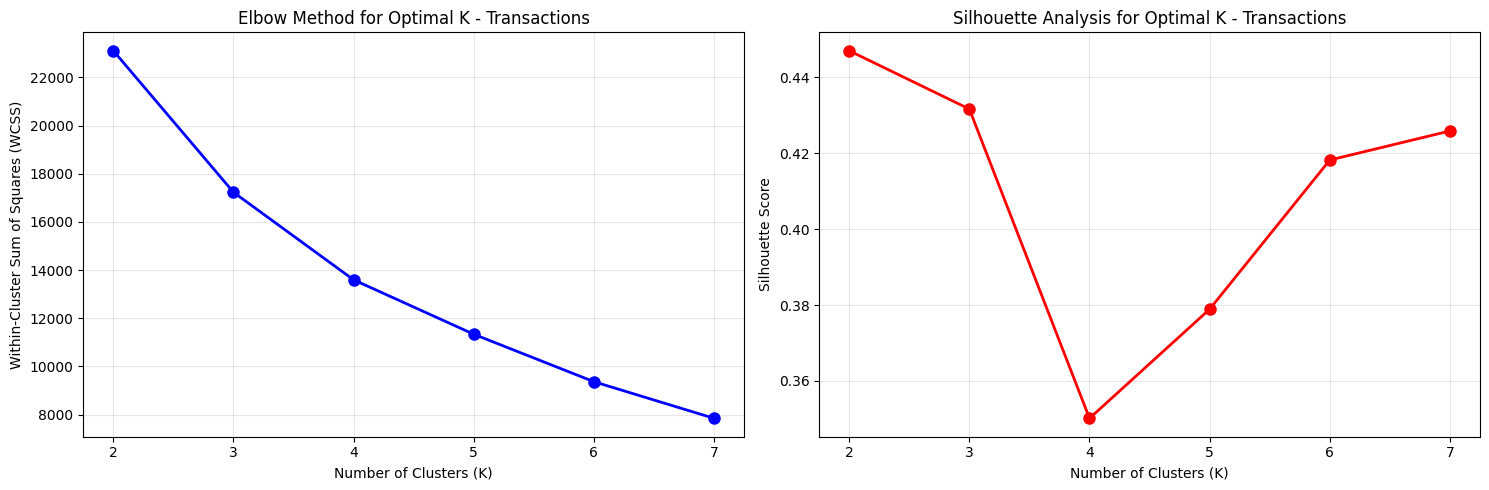


Optimal number of clusters for transactions: K = 2
Best silhouette score: 0.447


In [29]:
# Clusters
wcss_transaction = []
silhouette_scores_transaction = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_transaction_scaled)
    wcss_transaction.append(kmeans.inertia_)
    silhouette_scores_transaction.append(silhouette_score(X_transaction_scaled, kmeans.labels_))
    print(f"K={k}: WCSS = {kmeans.inertia_:.2f}, Silhouette = {silhouette_scores_transaction[-1]:.3f}")

# Plot the results
plt.figure(figsize=(15, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss_transaction, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K - Transactions')
plt.grid(True, alpha=0.3)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores_transaction, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K - Transactions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k_transaction = k_range[np.argmax(silhouette_scores_transaction)]
print(f"\nOptimal number of clusters for transactions: K = {optimal_k_transaction}")
print(f"Best silhouette score: {max(silhouette_scores_transaction):.3f}")

In [30]:
# prepare transaction-level features
transaction_clustering_features = [
    'tavg',
    'wspd',
    'prcp'
]

X_transaction = transaction_data[transaction_clustering_features].fillna(0)
X_transaction = X_transaction.replace([np.inf, -np.inf], 0)

scaler_transaction = StandardScaler()
X_transaction_scaled = scaler_transaction.fit_transform(X_transaction)

print(f"Transaction data shape: {X_transaction_scaled.shape}")

Transaction data shape: (9994, 3)


In [31]:
# Apply K-Means to transactions
optimal_k = 7
print(f"Applying K-Means with {optimal_k} clusters to transactions...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_transaction_scaled)
transaction_data['Cluster'] = cluster_labels

print(f"Number of transactions: {len(transaction_data)}")
print(f"\nCluster distribution:")
cluster_counts = transaction_data['Cluster'].value_counts().sort_index()
print(cluster_counts)


print(transaction_data[['Customer Name', 'Cluster', 'Sales', 'Quantity', 'Profit']].head(10))

Applying K-Means with 7 clusters to transactions...
Number of transactions: 9994

Cluster distribution:
Cluster
0    4037
1      36
2    1012
3     207
4    1071
5    1502
6    2129
Name: count, dtype: int64
      Customer Name  Cluster    Sales  Quantity  Profit
0     Darren Powers        0    16.45         2    5.55
1     Phillina Ober        2    11.78         3    4.27
2     Phillina Ober        2   272.74         3  -64.77
3     Phillina Ober        2     3.54         2   -5.49
4        Mick Brown        0    19.54         3    4.88
5  Lycoris Saunders        5    19.44         3    9.33
6     Jack O'Briant        0    12.78         3    5.24
7     Maria Etezadi        2  2573.82         9  746.41
8     Maria Etezadi        2   609.98         2  274.49
9     Maria Etezadi        2     5.48         2    1.48


In [32]:
# Find frequent itemsets 
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True, max_len=3)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Found {len(frequent_itemsets)} frequent itemsets")
print("\nTop 10 frequent itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

Found 0 frequent itemsets

Top 10 frequent itemsets:
Empty DataFrame
Columns: [support, itemsets, length]
Index: []


In [35]:
# Association analysis for each TRANSACTION CLUSTER
total_transactions = len(transaction_data['Transaction ID'].unique())

print("\nASSOCIATION ANALYSIS PER CLUSTER")

for cluster in sorted(transaction_data['Cluster'].unique()):
    cluster_data = transaction_data[transaction_data['Cluster'] == cluster]
    total_cluster_transactions = len(cluster_data['Transaction ID'].unique())
    
    # Get average weather conditions for this cluster
    avg_temp = cluster_data['tavg'].mean()
    avg_wind = cluster_data['wspd'].mean()
    avg_prcp = cluster_data['prcp'].mean()
    
    print(f"\nCLUSTER {cluster} (Avg: {avg_temp:.1f}°C, {avg_wind:.1f} km/h wind, {avg_prcp:.1f} mm rain)")
    print(f"Total transactions: {total_cluster_transactions}, Support: {(total_cluster_transactions/total_transactions)*100:.1f}%")
    
    if total_cluster_transactions > 0:
        # Find top products in this cluster
        product_counts = cluster_data['Sub-Category'].value_counts().head(5)
        
        for product, count in product_counts.items():
            overall_count = len(transaction_data[transaction_data['Sub-Category'] == product]['Transaction ID'].unique())
            overall_pct = (overall_count / total_transactions) * 100
            cluster_pct = (count / total_cluster_transactions) * 100
            support = (count / total_transactions) * 100
            lift = cluster_pct / overall_pct if overall_pct > 0 else 0
            
            print(f"  {product}: Support: {support:.1f}% | Confidence: {cluster_pct:.1f}% | Lift: {lift:.2f}")
            
            # Consequence interpretation
            if lift > 1.5:
                consequence = "= STRONG association with this cluster"
            elif lift > 1.2:
                consequence = "= Moderate association with this cluster"
            elif lift > 1.0:
                consequence = "= Mild association with this cluster"
            else:
                consequence = "= Less associated with this cluster"
                
            print(f"    {consequence}")
            print()
    
    # Top Items
    if 'Item' in cluster_data.columns:
        print(f" TOP SPECIFIC ITEMS IN CLUSTER {cluster}")
        item_counts = cluster_data['Item'].value_counts().head(3)
        
        for item, count in item_counts.items():
            item_support = (count / total_transactions) * 100
            item_confidence = (count / total_cluster_transactions) * 100
            print(f" = {item[:80]}...")  # Show first 80 chars to avoid too long lines
            print(f"     Support: {item_support:.1f}% | Confidence: {item_confidence:.1f}% | Lift: {lift:.2f}")
            print()


ASSOCIATION ANALYSIS PER CLUSTER

CLUSTER 0 (Avg: 13.8°C, 11.0 km/h wind, 1.8 mm rain)
Total transactions: 4037, Support: 40.4%
  Binders: Support: 6.0% | Confidence: 14.9% | Lift: 0.98
    = Less associated with this cluster

  Paper: Support: 5.3% | Confidence: 13.0% | Lift: 0.95
    = Less associated with this cluster

  Furnishings: Support: 4.1% | Confidence: 10.3% | Lift: 1.07
    = Mild association with this cluster

  Phones: Support: 3.5% | Confidence: 8.7% | Lift: 0.98
    = Less associated with this cluster

  Storage: Support: 3.4% | Confidence: 8.5% | Lift: 1.00
    = Mild association with this cluster

 TOP SPECIFIC ITEMS IN CLUSTER 0
 = Office Supplies_Fasteners_Staples...
     Support: 0.2% | Confidence: 0.5% | Lift: 1.00

 = Office Supplies_Envelopes_Staple envelope...
     Support: 0.2% | Confidence: 0.5% | Lift: 1.00

 = Office Supplies_Paper_Easy-staple paper...
     Support: 0.2% | Confidence: 0.4% | Lift: 1.00


CLUSTER 1 (Avg: 17.8°C, 11.8 km/h wind, 40.5 mm rai